In [93]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

from keras import models
from keras import layers
from sklearn.metrics import mean_absolute_error 
from keras import regularizers
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint


#Function to load the data 
def load_crime_data():
    
    attributes = ['state' ,'county' ,'community' ,'communityname' ,'fold' ,'population' ,'householdsize' ,'racepctblack' ,'racePctWhite' ,'racePctAsian' ,'racePctHisp' ,'agePct12t21' 
                  ,'agePct12t29' ,'agePct16t24' ,'agePct65up' ,'numbUrban' ,'pctUrban' ,'medIncome' ,'pctWWage' ,'pctWFarmSelf' ,'pctWInvInc' ,'pctWSocSec' ,'pctWPubAsst' ,'pctWRetire' 
                  ,'medFamInc' ,'perCapInc' ,'whitePerCap' ,'blackPerCap' ,'indianPerCap' ,'AsianPerCap' ,'OtherPerCap' ,'HispPerCap' ,'NumUnderPov' ,'PctPopUnderPov' ,'PctLess9thGrade' 
                  ,'PctNotHSGrad' ,'PctBSorMore' ,'PctUnemployed' ,'PctEmploy' ,'PctEmplManu' ,'PctEmplProfServ' ,'PctOccupManu' ,'PctOccupMgmtProf' ,'MalePctDivorce' ,'MalePctNevMarr' 
                  ,'FemalePctDiv' ,'TotalPctDiv' ,'PersPerFam' ,'PctFam2Par' ,'PctKids2Par' ,'PctYoungKids2Par' ,'PctTeen2Par' ,'PctWorkMomYoungKids' ,'PctWorkMom' ,'NumIlleg' ,'PctIlleg' 
                  ,'NumImmig' ,'PctImmigRecent' ,'PctImmigRec5' ,'PctImmigRec8' ,'PctImmigRec10' ,'PctRecentImmig' ,'PctRecImmig5' ,'PctRecImmig8' ,'PctRecImmig10' ,'PctSpeakEnglOnly' 
                  ,'PctNotSpeakEnglWell' ,'PctLargHouseFam' ,'PctLargHouseOccup' ,'PersPerOccupHous' ,'PersPerOwnOccHous' ,'PersPerRentOccHous' ,'PctPersOwnOccup' ,'PctPersDenseHous' 
                  ,'PctHousLess3BR' ,'MedNumBR' ,'HousVacant' ,'PctHousOccup' ,'PctHousOwnOcc' ,'PctVacantBoarded' ,'PctVacMore6Mos' ,'MedYrHousBuilt' ,'PctHousNoPhone' ,'PctWOFullPlumb' 
                  ,'OwnOccLowQuart' ,'OwnOccMedVal' ,'OwnOccHiQuart' ,'RentLowQ' ,'RentMedian' ,'RentHighQ' ,'MedRent' ,'MedRentPctHousInc' ,'MedOwnCostPctInc' ,'MedOwnCostPctIncNoMtg' 
                  ,'NumInShelters' ,'NumStreet' ,'PctForeignBorn' ,'PctBornSameState' ,'PctSameHouse85' ,'PctSameCity85' ,'PctSameState85' ,'LemasSwornFT' ,'LemasSwFTPerPop' ,'LemasSwFTFieldOps' 
                  ,'LemasSwFTFieldPerPop' ,'LemasTotalReq' ,'LemasTotReqPerPop' ,'PolicReqPerOffic' ,'PolicPerPop' ,'RacialMatchCommPol' ,'PctPolicWhite' ,'PctPolicBlack' ,'PctPolicHisp' 
                  ,'PctPolicAsian' ,'PctPolicMinor' ,'OfficAssgnDrugUnits' ,'NumKindsDrugsSeiz' ,'PolicAveOTWorked' ,'LandArea' ,'PopDens' ,'PctUsePubTrans' ,'PolicCars' ,'PolicOperBudg' 
                  ,'LemasPctPolicOnPatr' ,'LemasGangUnitDeploy' ,'LemasPctOfficDrugUn' ,'PolicBudgPerPop' ,'ViolentCrimesPerPop']
    data = read_csv('communities.data', names = attributes)
    #removing data that cannot be processed due to different data types
    data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
    return data   


                    
#loading and data preprocessing the data

from pandas import DataFrame
data = load_crime_data()
#replace question mark by Nan
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]

# Impute mean values for samples with missing values

from sklearn.impute import SimpleImputer
replace = SimpleImputer(missing_values = np.nan, strategy = 'median') #OtherPerCap column has only one missing value 
replace = imputer.fit(data[['OtherPerCap']])                        #so I am  replacing with mean value
data[['OtherPerCap']] = replace.transform(data[['OtherPerCap']])
#Drop all other columns
data = data.dropna(axis=1) 

#input and lables
X = data
Y = data.pop('ViolentCrimesPerPop')

#spliting the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

x_train_mean = np.mean(X_train)
x_train_std = np.std(X_train)
X_train = (X_train - x_train_mean)/x_train_std
X_test = (X_test - x_train_mean)/x_train_std


In [94]:
def build_model():
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(100,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse', metrics=['mae'])
    checkpointer = ModelCheckpoint(filepath="weights.finalmodel", verbose=0, save_best_only=True)
    callbacks_list = [checkpointer]
    return model

In [97]:
# k Fold cross validation

k = 4
num_val_samples = len(X_train)//k
num_epochs = 200
all_scores = []
all_mae_histories = []
callbacks_list = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_X = X_train[i *num_val_samples: (i + 1) *num_val_samples]
    val_Y = Y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_X = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_Y = np.concatenate(
        [Y_train[:i * num_val_samples],
         Y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_X, partial_train_Y,
                        epochs=num_epochs, batch_size=1, 
                        verbose=0, validation_data = (val_X,val_Y),
                        callbacks=callbacks_list)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_X, val_Y, verbose=0)
    all_scores.append(val_mae)

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [98]:
all_scores

[0.13888193666934967,
 0.130196675658226,
 0.14208023250102997,
 0.1334351897239685]

In [99]:
np.mean(all_scores)

0.13614850863814354

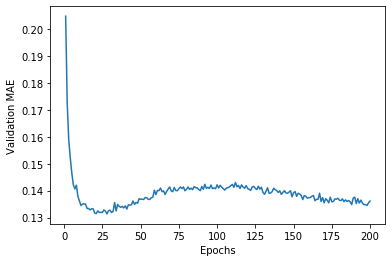

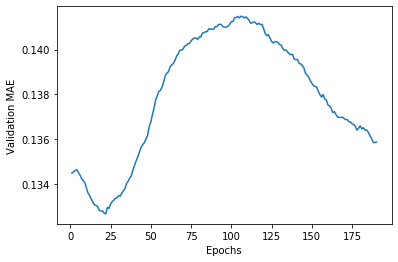

In [100]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

# plt.plot(history.history['loss'])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [102]:
model = build_model()
model.fit(X_train,Y_train,
         epochs = 25, batch_size = 20, verbose = 0)
test_mse, test_mae = model.evaluate(X_test,Y_test)
print(test_mae)

399/399 [==============================] - 0s 49us/step
0.13749772310256958
